In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Outline
* ## Load data
* ## Explore the data
* ## Preprocessing
* ## Feature Engineering
* ## Fitting Baseline Models
* ## Finding the Best Model
* ## Create Submission
* ## Merging with Movies Data

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the data

In [3]:
train_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
movies_data= pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

In [4]:
train_data.head()#returns first 5 rows

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [5]:
test_data.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


#### Test data has isTopCritic column instead of isFrequentReviewer 

In [6]:
movies_data.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [7]:
print("Shape of Datasets","\nMovie Data:" ,movies_data.shape , "\nTrain Data:", train_data.shape, "\nTest Data:", test_data.shape)

Shape of Datasets 
Movie Data: (143258, 14) 
Train Data: (162758, 5) 
Test Data: (55315, 4)


# Exploring the datasets

## Identifying the data types for each feature

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [10]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [11]:
train_data['isFrequentReviewer'].unique()

array([False,  True])

In [12]:
train_data['sentiment'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

## Getting some statistics about the data

In [13]:
train_data.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


#### The count of reviewText is less than the count of other columns, null values are expected in reviewText

In [14]:
movies_data.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


#### The range for audienceScore is 0-100 and for runtimeMinutes its 1-2700 minutes

In [15]:
test_data.describe()

,movieid,reviewerName,isTopCritic,reviewText
count,55315,55315,55315,52805
unique,16786,4495,2,52686
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review
freq,230,428,38428,12


## Inferences after exploring the data:
* Training dataset has 5 columns, 2 of them are boolean
* Count of reviewText is less than others so there might be missing values
* Intuitively it makes sense, the sentiment column corresponds to the sentiment of the review.
* So train the model only using reviewText


### Relation between isFrequentReviewer and sentiment in Training Data

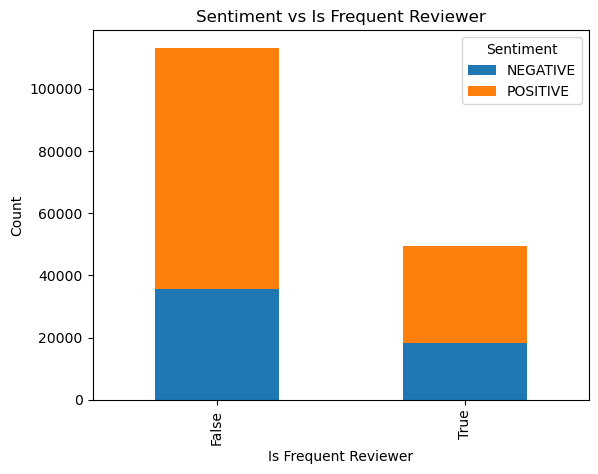

In [16]:
cross_tab = pd.crosstab(train_data['isFrequentReviewer'], train_data['sentiment'])

# Plot a stacked bar plot
cross_tab.plot(kind='bar', stacked=True)
plt.xlabel('Is Frequent Reviewer')
plt.ylabel('Count')
plt.title('Sentiment vs Is Frequent Reviewer')
plt.legend(title='Sentiment')
plt.show()

In [17]:
print(cross_tab)

sentiment           NEGATIVE  POSITIVE
isFrequentReviewer                    
False                  35760     77429
True                   18237     31332


In [18]:
grouped_counts = train_data.groupby(['isFrequentReviewer', 'sentiment']).size()
total_counts = grouped_counts.groupby('isFrequentReviewer').sum()
proportions = (grouped_counts / total_counts) * 100
print(proportions)

isFrequentReviewer  sentiment
False               NEGATIVE     31.593176
                    POSITIVE     68.406824
True                NEGATIVE     36.791140
                    POSITIVE     63.208860
dtype: float64


#### Inference: For both frequent and non frequent reviewers the proportion of postive and negative sentiment is similar

## Visualising the Sentiment column in Training Data

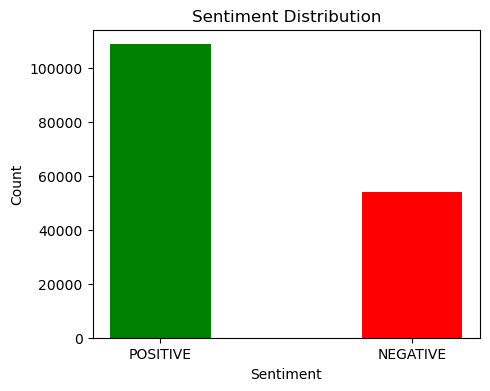

POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64

In [19]:
sentiment_counts = train_data["sentiment"].value_counts()

#Creating a bar plot
plt.figure(figsize= (5,4))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=["green","red"], width = 0.4)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

#print the actual values as well
sentiment_counts

#### Number of positive reviews is almost 2 times the negative reviews

# Approach 1 - Using only train_data[reviewText] and test_data for training

# Preprocessing

### Finding missing values

In [20]:
train_data.isna().sum()#returns no of null values for each column

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

##### 6447 null values in reviewText

In [21]:
test_data.isna().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

##### 2510 null values in test data

### Handling missing values in train_data

Several Approaches to deal with missing_values
1. Drop them
2. Imputation

In [22]:
train_data["reviewText"][:5]

0    Henry Selick’s first movie since 2009’s Corali...
1    With a cast that reads like the Vogue Oscar pa...
2    Creed II does not give us anything but another...
3    I know what you're thinking, but this is no Li...
4    Director Fernando Meirelles tells the story wi...
Name: reviewText, dtype: object

### Dropping the missing values

In [23]:
print(train_data.shape)
train_data.dropna(inplace = True)
print(f"Shape of train_data after dropping missing values; {train_data.shape}")

(162758, 5)
Shape of train_data after dropping missing values; (156311, 5)


In [24]:
train_data.isna().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
dtype: int64

### Verifying that there are no null values now 

## Spliting the training data

In [25]:
X = train_data['reviewText'] #using only reviewText
y = train_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}\nShape of X_test: {X_test.shape}\nShape of y_train: {y_train.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train: (125048,)
Shape of X_test: (31263,)
Shape of y_train: (125048,)
Shape of y_test: (31263,)


## Vectorizing the data

In [26]:
vectorizer = CountVectorizer(stop_words = 'english')
label_encoder = LabelEncoder()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [27]:
print(X_train.toarray(),f"\n Shape of X_train after vectorization: {X_train.shape}", f"\n Shape of X_test after vectorization: {X_test.shape}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
 Shape of X_train after vectorization: (125048, 59749) 
 Shape of X_test after vectorization: (31263, 59749)


#### from the shape it can be observed that there are 59749 words in the vocabulary

In [28]:
print(f"\n Shape of y_train after encoding: {y_train.shape}", f"\n Shape of y_test after encoding: {y_test.shape}")


 Shape of y_train after encoding: (125048,) 
 Shape of y_test after encoding: (31263,)


## Exploring the vocabulary
#### Getting the top 100 frequent words and their word count

In [29]:
vocabulary = vectorizer.vocabulary_
word_counts = np.array(X_train.sum(axis=0)).flatten()


# Get the indices of the top 100 words
top_100_indices = np.argsort(word_counts)[::-1][:100]

# Get the most frequent 100 words and their counts
most_frequent_words = []
for idx in top_100_indices:
    word = list(vocabulary.keys())[list(vocabulary.values()).index(idx)]
    most_frequent_words.append(word)
    
most_frequent_counts = word_counts[top_100_indices]

num_rows = 20
num_columns = 5

for i in range(0, len(most_frequent_words), num_columns):
    words_slice = most_frequent_words[i:i+num_columns]
    counts_slice = most_frequent_counts[i:i+num_columns]
    print("\t".join(f"{word}-{count}" for word, count in zip(words_slice, counts_slice)))

film-21445	movie-14515	like-8721	story-7470	46-6898
just-5843	44-5631	good-5410	time-4659	best-4296
director-4160	comedy-4066	way-3935	make-3843	life-3694
characters-3642	action-3413	little-3410	doesn-3376	makes-3271
great-3254	review-3194	fun-3143	drama-3029	work-3026
funny-2925	does-2912	performance-2909	spanish-2891	love-2877
new-2828	films-2805	movies-2734	performances-2687	world-2632
feels-2537	thriller-2484	better-2478	character-2470	isn-2439
horror-2424	really-2367	man-2345	cast-2302	long-2232
people-2165	year-2160	entertaining-2158	real-2157	feel-2128
old-2074	don-2064	bad-2015	end-2008	plot-1994
big-1926	tale-1926	family-1920	look-1917	8217-1872
quite-1847	far-1842	heart-1834	sense-1824	moments-1813
right-1803	script-1797	kind-1791	lot-1790	hard-1779
documentary-1767	screen-1752	ve-1722	audience-1704	genre-1675
original-1641	emotional-1598	watch-1546	takes-1536	seen-1522
bit-1521	come-1515	despite-1513	high-1509	human-1455
know-1447	thing-1445	making-1422	self-1422	going-1416


## Visualising the count for first 100 words

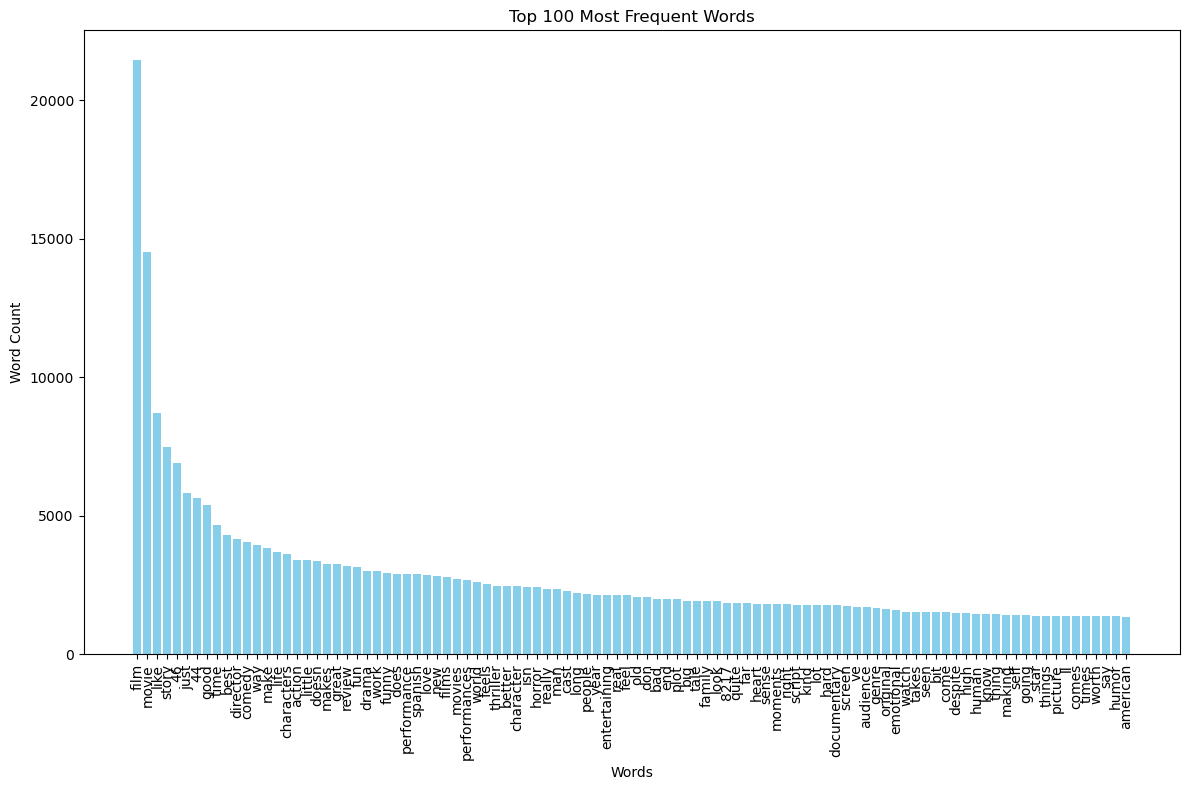

In [30]:
plt.figure(figsize=(12, 8))
plt.bar(range(len(most_frequent_words)), most_frequent_counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('Top 100 Most Frequent Words')
plt.xticks(range(len(most_frequent_words)), most_frequent_words, rotation=90)
plt.tight_layout()
plt.show()

#### The word film and movie have the highest count, which is expected

#### Why "46" has so high count?

In [31]:
rows_with_46 = X[X.str.contains("46")]
pd.set_option('display.max_colwidth', None)
# 'filtered_rows' now contains only the rows where 'reviewText' contains the string "46"
print(rows_with_46[:5])

175                                                                                                                                                                            Jenkins&apos; handling of Chiron&apos;s sexuality is as quietly oblique as everything else in the film&#46;
227                                                                                                                                                                                                          A fruitless franchise launch for a series I doubt we will ever see again&#46;
263    Thinking back on &quot;Suspiria&quot; yields sense memories&#44; electronic haunted-house sounds&#44; stylish and outr&#233; brutality&#46; It&apos;s possible to forget Harper is even in it&#44; but it&apos;s not possible to forget the opening salvo of operatic violence&#46;
300                                            There&#8217;s some macabre glee&#44; but you&#8217;ll leave wanting more&#46; Or at least a lot less of 

#### Observation: The string 46 is randomly occuring between reviews

# Fitting Baseline Models

In [32]:
def model_fit(model):
    model.fit(X_train, y_train)
    score_train = model.score(X_train,y_train)
    print("Training score:",score_train)
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    
    print(f"Testing Score for {model}: {score}\n")
    
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

## Linear SVC

In [33]:
svc = LinearSVC()
model_fit(svc)

Training score: 0.9231255198003967
Testing Score for LinearSVC(): 0.7751335444455106

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.62      0.64     10148
           1       0.82      0.85      0.84     21115

    accuracy                           0.78     31263
   macro avg       0.74      0.74      0.74     31263
weighted avg       0.77      0.78      0.77     31263



##### The model performs better on class 1 than on class 0 in terms of precision, recall, and F1-score. The model is more adept at identifying instances belonging to class 1.

## LogisticRegression

In [34]:
log_reg = LogisticRegression()
model_fit(log_reg)

Training score: 0.8822212270488132
Testing Score for LogisticRegression(): 0.796212775485398

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.62      0.66     10148
           1       0.83      0.88      0.85     21115

    accuracy                           0.80     31263
   macro avg       0.77      0.75      0.76     31263
weighted avg       0.79      0.80      0.79     31263



##### The model performs better on class 1 than on class 0 in terms of precision, recall, and F1-score. The model is more adept at identifying instances belonging to class 1.

## BernoulliNB

In [35]:
bnb = BernoulliNB()
model_fit(bnb)

Training score: 0.8512251295502528
Testing Score for BernoulliNB(): 0.7989316444359147

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67     10148
           1       0.83      0.88      0.86     21115

    accuracy                           0.80     31263
   macro avg       0.77      0.75      0.76     31263
weighted avg       0.79      0.80      0.80     31263



##### The model performs better on class 1 than on class 0 in terms of precision, recall, and F1-score. The model is more adept at identifying instances belonging to class 1.

## Model Performance Summary
1. Logistic Regression - 0.796
2. BernouilliNB - 0.798
3. LinearSVC - 0.775

### All the models were better at predicting class 1 it can be due to slight imbalance in the dataset

## Feature Selection
For feature selection, tried PCA didnt yield good results

In [36]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=500)  # number of components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(125048, 500)


In [37]:
def model_fit_pca(model):
    model.fit(X_train_pca,y_train)
    score = model.score(X_test_pca,y_test)
    y_pred = model.predict(X_test_pca)
    print("Model Score: ", score, "\n", ConfusionMatrixDisplay.from_predictions(y_test,y_pred))

Model Score:  0.7407478488948598 


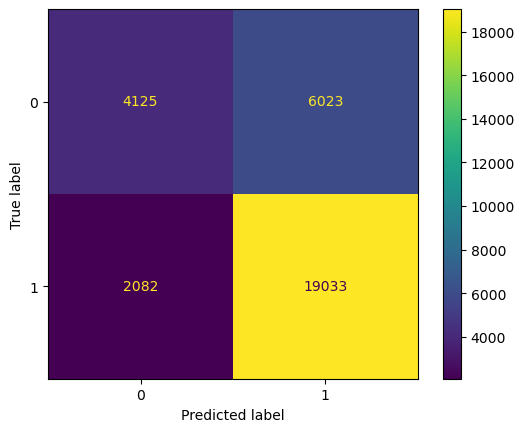

In [38]:
model_fit_pca(log_reg)

### Observation: PCA didnt improve the performance

# Tuning hyperparameter for Logistic regression


In [39]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()

# from scipy.stats import uniform
# # Define the hyperparameter grid
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C': uniform(loc=0, scale=10),
#     'solver': ['liblinear', 'saga']
# }

# # Create a RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=10,  # Number of parameter settings that are sampled
#     cv=5,  # Cross-validation splitting strategy
#     random_state=42
# )

# # Fitting the RandomizedSearchCV object to the data
# random_search.fit(X_train, y_train)

# # Print the best hyperparameters found
# print("Best hyperparameters found:")
# print(random_search.best_params_)

# # Print the best score achieved
# print("Best score:", random_search.best_score_)

### Tuning Hyperparamter for BernouilleNB

In [40]:
# param_grid = {
#     'alpha': np.logspace(-3, 3, 7),  # Range of alpha values to try
#     'binarize': np.linspace(0.0, 1.0, 11)  # Range of binarize values to try
# }


# clf = BernoulliNB()


# random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=20, cv=5, random_state=42)

# # Fitting the RandomizedSearchCV instance on the training data
# random_search.fit(X_train, y_train)

# # Print the best hyperparameters found
# print("Best hyperparameters:", random_search.best_params_)

# # Evaluate the best model on the test set
# best_model = random_search.best_estimator_
# test_accuracy = best_model.score(X_test, y_test)
# print("Test accuracy:", test_accuracy)

## Using VotingClassifier
### BernoulliNB and LogisticRegresion performed best so trying voting classifier with them

In [41]:
# Define the base models
base_models = [('bernoulli', BernoulliNB()), ('logistic', LogisticRegression(C = 0.205,  penalty = 'l2',solver = 'saga' ))]

# Define the stacking classifier with MLPClassifier as the final estimator
voting_clf = VotingClassifier(estimators=base_models,voting= 'hard')

In [42]:
model_fit(voting_clf)

Training score: 0.8558393576866483
Testing Score for VotingClassifier(estimators=[('bernoulli', BernoulliNB()),
                             ('logistic',
                              LogisticRegression(C=0.205, solver='saga'))]): 0.8023222339506765

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69     10148
           1       0.85      0.86      0.85     21115

    accuracy                           0.80     31263
   macro avg       0.77      0.77      0.77     31263
weighted avg       0.80      0.80      0.80     31263



#### Voting Classifer is giving the highest score

## Wrapping things inside a pipeline


In [43]:
X = train_data['reviewText']
y = train_data['sentiment']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}\nShape of X_test: {X_test.shape}\nShape of y_train: {y_train.shape}\nShape of y_test: {y_test.shape}")

Shape of X_train: (125048, 59749)
Shape of X_test: (31263, 59749)
Shape of y_train: (125048,)
Shape of y_test: (31263,)


Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       0.69      0.72      0.70     10148
    POSITIVE       0.86      0.85      0.85     21115

    accuracy                           0.80     31263
   macro avg       0.78      0.78      0.78     31263
weighted avg       0.81      0.80      0.81     31263



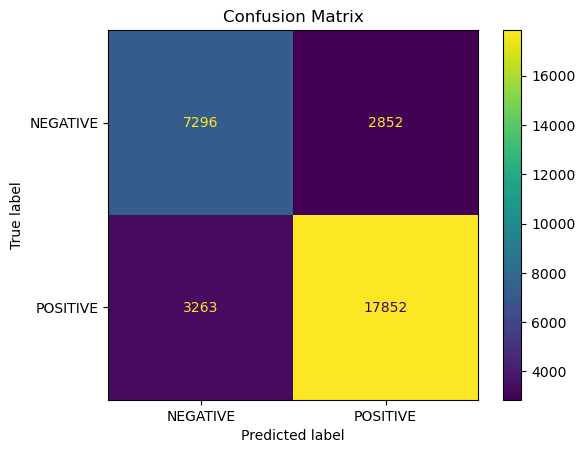

Testing Score: 0.8044013690304833



In [44]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', voting_clf)
])

pipeline.fit(X_train_p, y_train_p)
y_pred = pipeline.predict(X_test_p)
report = classification_report(y_test_p, y_pred)
print("Classification Report:\n", report)

disp = ConfusionMatrixDisplay.from_predictions(y_test_p,y_pred) 
plt.title("Confusion Matrix")
plt.show()
score = pipeline.score(X_test_p, y_test_p)
print(f"Testing Score: {score}\n")

## Creating submission for Voting Classifier model

In [45]:
def create_submission(test_data,model,X,y):
    model.fit(X,y)
    test_data.fillna('', inplace=True)
    test = vectorizer.transform(test_data['reviewText'])
    predictions = model.predict(test)
    predictions = label_encoder.inverse_transform(predictions)
    id = np.arange(55315)
    submission_df = pd.DataFrame({'id':id,'sentiment': predictions })
    submission_df.to_csv('submission.csv',index = False)
    print("Submission Created")

### Transforming test data

In [46]:
X = vectorizer.transform(X)
y = label_encoder.transform(y)


In [47]:
create_submission(test_data,voting_clf,X,y)

Submission Created


In [48]:
# create_submission(test_data,LogisticRegression(C = 0.205,  penalty = 'l2',solver = 'saga' ),X,y)

# Approach 2: Merging Movies data with train and test data

## Exploring Movies data

In [49]:
movies_data.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_vito_corleone,Norman Bates Ferris Bueller Hermione Granger Vito Corleone,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


### Observing basic statistics

In [50]:
movies_data.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


In [51]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


### Checking for null values

In [52]:
movies_data.isna().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [53]:
print(f"Total unique movieid: {len(movies_data['movieid'].unique())}\nShape of movies_data {movies_data.shape}")

Total unique movieid: 126404
Shape of movies_data (143258, 14)


#### Observation: number of unique movied is less than total rows in the movies_data which means there are duplicate movieid

## Removing Duplicates from Movies data

In [54]:
movies_data = movies_data.drop_duplicates(subset='movieid', keep='first')
movies_data.reset_index(drop=True, inplace=True)

### To utilise the information in movies_data we need to merge it with train data

## Merging Movies data and train data

In [55]:
merged_train = pd.merge(train_data, movies_data, on='movieid')

# Print the information of the merged DataFrame
print(merged_train.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 156311 entries, 0 to 156310
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               156311 non-null  object 
 1   reviewerName          156311 non-null  object 
 2   isFrequentReviewer    156311 non-null  bool   
 3   reviewText            156311 non-null  object 
 4   sentiment             156311 non-null  object 
 5   title                 156311 non-null  object 
 6   audienceScore         143554 non-null  float64
 7   rating                97268 non-null   object 
 8   ratingContents        97268 non-null   object 
 9   releaseDateTheaters   122238 non-null  object 
 10  releaseDateStreaming  140789 non-null  object 
 11  runtimeMinutes        153059 non-null  float64
 12  genre                 153965 non-null  object 
 13  originalLanguage      153168 non-null  object 
 14  director              156311 non-null  object 
 15  

### Exploring merged_data

In [56]:
merged_train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Coraline. His fifth stop-motion masterpiece.,POSITIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
1,marvelous_pirate,Sharon Foster,False,&#91;T&#93;he haphazard way this story is assembled makes it seem as if the filmmakers were more concerned with &#46;&#46;&#46; &#91;the&#93; little details than the bigger ones&#46;,NEGATIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
2,marvelous_pirate,Melinda Dunn,False,The stop-motion artistry of Wendell &amp; Wild is exquisite&#44; but the story leaves much to be desired&#46;,POSITIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
3,marvelous_pirate,Mr. Wayne Smith,False,Wendell &amp; Wild is narratively overstuffed past its limits&#44; losing its protagonist and the impact of her journey in the chaos&#46;,NEGATIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
4,marvelous_pirate,Connor Nelson,False,For being about the Netherworlds&#44; it&#8217;s very warm and inviting&#46;,POSITIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN


### Finding missing values in merged train data

In [57]:
merged_train.isna().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText                  0
sentiment                   0
title                       0
audienceScore           12757
rating                  59043
ratingContents          59043
releaseDateTheaters     34073
releaseDateStreaming    15522
runtimeMinutes           3252
genre                    2346
originalLanguage         3143
director                    0
boxOffice               50353
distributor             38462
soundType               82960
dtype: int64

#### Lots of column with null values

### Some inferences
#### 1. ratingContents and Genre have a list of categorical values
#### 2. distributor,originalLanguage and director are also categorical columns
#### 3. isFrequentReviewer and sentiment have boolean values
#### 4. rating,audienceScore have numerical values
#### 5. reviewText, title, movieid have string values

### Exploring the genre column

In [58]:
#since genre has many missing values lets deal with them first
merged_train["genre"] = merged_train["genre"].fillna('')
genre_tags = set()

#find all the unique genres
for i in merged_train['genre']:
    for tag in i.split(','):
        if tag.strip() not in genre_tags: ## removing whitespace as well
            genre_tags.add(tag.strip())
print(genre_tags,"\n\n", f"Length of genre tags: {len(genre_tags)}")

{'Action', '', 'Romance', 'Mystery & thriller', 'Sports', 'War', 'Holiday', 'Drama', 'Health & wellness', 'Fantasy', 'Western', 'Faith & spirituality', 'Kids & family', 'Gay & lesbian', 'Crime', 'Adventure', 'Variety', 'Animation', 'Other', 'Anime', 'Sports & fitness', 'Nature', 'News', 'Biography', 'History', 'Foreign', 'Comedy', 'Short', 'Stand-up', 'Lgbtq+', 'Documentary', 'Music', 'Horror', 'Sci-fi', 'Musical'} 

 Length of genre tags: 35


In [59]:
genre_tags.remove('')

#### There are 34 tags in genre maybe we can use them after encoding

In [60]:
#creating a dictionary which has key as genre and value is a tuple ~ (no_of_postive_reviews,no_of_negative_reviews )
def count_pos_neg_for_each_genre(genre):
    #check if a genre is there in a row or not
    def has_genre(genre_str):
        return genre in genre_str
    positive_movies = merged_train[(merged_train["genre"].apply(has_genre)) &(merged_train["sentiment"]=="POSITIVE")]
    negative_movies = merged_train[(merged_train["genre"].apply(has_genre)) &(merged_train["sentiment"]=="NEGATIVE")]
    return len(positive_movies), len(negative_movies)
genre_pos_neg = {}

#call the function for each genre
for genre in genre_tags:
    genre_pos_neg[genre] = count_pos_neg_for_each_genre(genre)
print(genre_pos_neg)

{'Action': (13936, 9946), 'Romance': (8778, 5341), 'Mystery & thriller': (19205, 11064), 'Sports': (28, 9), 'War': (2163, 861), 'Holiday': (812, 654), 'Drama': (51036, 20568), 'Health & wellness': (3, 0), 'Fantasy': (9238, 5030), 'Western': (1156, 496), 'Faith & spirituality': (1, 0), 'Kids & family': (5918, 3293), 'Gay & lesbian': (1, 0), 'Crime': (6124, 2637), 'Adventure': (13835, 7678), 'Variety': (1, 0), 'Animation': (4533, 1710), 'Other': (2, 0), 'Anime': (595, 127), 'Sports & fitness': (18, 5), 'Nature': (6, 2), 'News': (1, 0), 'Biography': (5594, 2046), 'History': (4831, 1853), 'Foreign': (8, 2), 'Comedy': (29776, 16882), 'Short': (3, 0), 'Stand-up': (24, 2), 'Lgbtq+': (2689, 918), 'Documentary': (10697, 1893), 'Music': (3886, 1429), 'Horror': (8260, 5121), 'Sci-fi': (6755, 3952), 'Musical': (1949, 1002)}


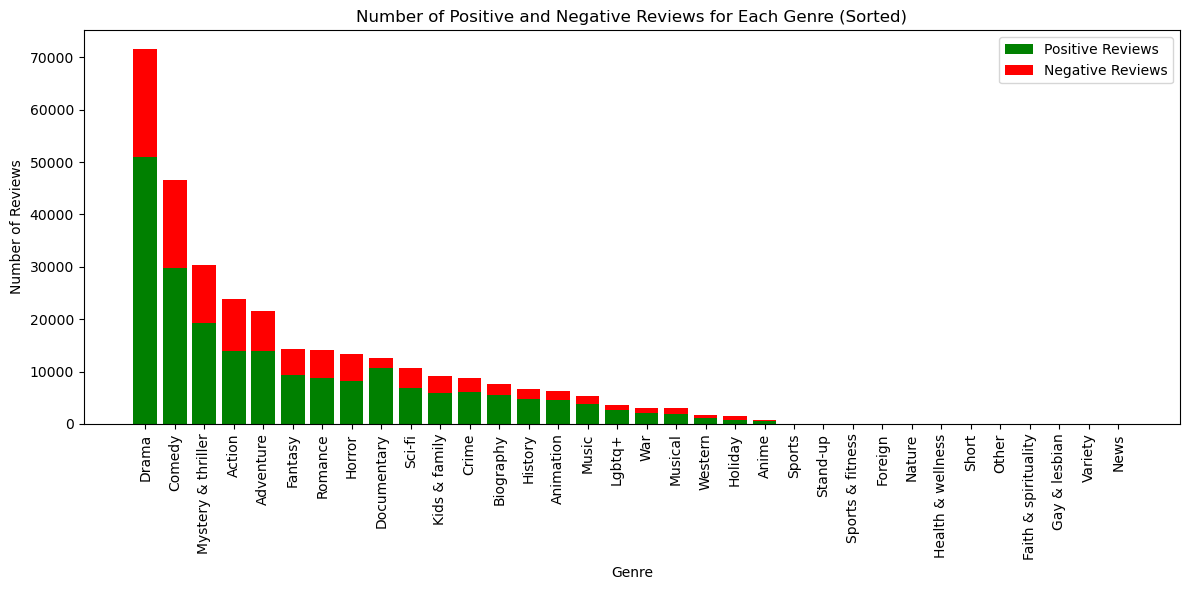

In [61]:
# Calculate total counts for each genre
total_counts = [sum(count) for count in genre_pos_neg.values()]

# Sort genres based on total counts
sorted_indices = sorted(range(len(total_counts)), key=lambda k: total_counts[k], reverse=True)
sorted_genres = [list(genre_pos_neg.keys())[i] for i in sorted_indices]
sorted_positive_counts = [list(genre_pos_neg.values())[i][0] for i in sorted_indices]
sorted_negative_counts = [list(genre_pos_neg.values())[i][1] for i in sorted_indices]

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(sorted_genres, sorted_positive_counts, label='Positive Reviews', color='green')
plt.bar(sorted_genres, sorted_negative_counts, bottom=sorted_positive_counts, label='Negative Reviews', color='red')
plt.xlabel('Genre')
plt.ylabel('Number of Reviews')
plt.title('Number of Positive and Negative Reviews for Each Genre (Sorted)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

#### There are 34 genres, they can be used after one hot encoding them, but this in turn will increase the dimensionality. Genre doesnt seem to effect the chance of review being positive or negative since the proportion of both positive and negative looks similar. So using genre for training is not worth it at the expense of increasing dimensionality.

## Exploring ratingContents column in merged train dataset


In [62]:
merged_train["ratingContents"][:5]

0    ['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']
1    ['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']
2    ['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']
3    ['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']
4    ['Violence', 'Brief Strong Language', 'Substance Use', 'Some Thematic Material']
Name: ratingContents, dtype: object

#### Finding total unique tags in ratingContents

In [63]:
import ast
#deal with NaN values, fill them with empty list
merged_train["ratingContents"] = merged_train["ratingContents"].fillna("[]")

#convert the string to list
merged_train["ratingContents"] = merged_train["ratingContents"].apply(ast.literal_eval)

rating_content_set = set() #unique ratingContents
for i in merged_train["ratingContents"]:
    for tag in i:
        if tag not in rating_content_set:
            rating_content_set.add(tag)
            
print(len(rating_content_set))

1538


#### Rating Contents has 1538 unique values, adding them as one hot encoded vectors will increase the dimensionality so dropping them as well

## Merge movies data and test data

In [64]:
merged_test = pd.merge(test_data, movies_data, on='movieid')
merged_test.shape

(55315, 17)

In [65]:
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieid               55315 non-null  object 
 1   reviewerName          55315 non-null  object 
 2   isTopCritic           55315 non-null  bool   
 3   reviewText            55315 non-null  object 
 4   title                 55315 non-null  object 
 5   audienceScore         50384 non-null  float64
 6   rating                31019 non-null  object 
 7   ratingContents        31019 non-null  object 
 8   releaseDateTheaters   41613 non-null  object 
 9   releaseDateStreaming  49341 non-null  object 
 10  runtimeMinutes        54053 non-null  float64
 11  genre                 54395 non-null  object 
 12  originalLanguage      54077 non-null  object 
 13  director              55315 non-null  object 
 14  boxOffice             35320 non-null  object 
 15  distributor        

## Preprocessing Merged train data

### Dropping unnecessary columns intuitively

### Training the model using 'movieid', 'director', 'reviewText', 'title','audienceScore' only

In [66]:
from sklearn.compose import make_column_transformer

#choosing the below columns
X_m = merged_train[['movieid', 'director', 'reviewText', 'title','audienceScore']]

#target variable
y_m = merged_train['sentiment']

#splitting
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42)

#Preprocessing

#preprocessing target variable
label_encoder_m = LabelEncoder()
y_train_encoded = label_encoder_m.fit_transform(y_train_m)
y_test_encoded = label_encoder_m.transform(y_test_m)

#preprocessing target feature using TfidfVectorizer for strings and simple imputer for numerical values
vect = TfidfVectorizer()
sim_imp = SimpleImputer()
scaler = StandardScaler()

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])
#creating transformer
ct_tf = make_column_transformer((vect,'movieid'),(vect,"director"),(vect, "title"), (numerical_transformer, ['audienceScore']))
X_train_transformed = ct_tf.fit_transform(X_train_m)

#fitting the transformer with baseline model
log_reg_m = LogisticRegression()
log_reg_m.fit(X_train_transformed,y_train_encoded)

#checking the accuracy for Logistic Regresion
X_test_transformed = ct_tf.transform(X_test_m)
y_pred_m = log_reg_m.predict(X_test_transformed)
print(accuracy_score(y_test_encoded,y_pred_m))

0.7474010811502415


## After merging the score did not improve